# MottanAI: Garbage Classifier using CNN
The app mottainAI is an AI app that uses computer vision and machine learning to distinguish whether a piece of trash is either burnable/combustible or non-burnable/incombustible.

This project is developed by: 
- L. A. Gallos (THX)
- J. Hechanova (THX)
- T. K. Llanto (THX)
- M. Pardinas (THW)



### Background
Mottainai is a Japanese word or phrase that loosely translates to “wasteful” or the feeling of having wasted something which might have had certain value. In order to promote efficient and responsible waste management, Japan has adopted a circular economy which aims to minimize waste and maximize utilization of current resources through proper waste management. To aid in this mission, the group proposes an application called mottainAI which uses both machine learning and computer vision to aid in identifying and distributing between different types of waste.

### Import Libraries
This implementation mainly uses Tensorflow and Keras as a tool to create the model.

In [1]:
import os
import pathlib
import numpy as np

# for image preprocessing
from PIL import Image, ImageOps
from imageio import imread, imwrite

# for model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# for visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

### Global Constants

In [2]:
# Used for standardizing image size
img_height = 180
img_width = 180

### Preprocessing
The initial dataset that is used in this project can be found in https://github.com/garythung/trashnet. It contains a collection of garbage classified into 6 categories (paper, cardboard, plastic, trash, glass, and metal). For the purpose of this project, the dataset is divided into only two categories (burnable vs nonburnable).

All paper, cardboard, plastic, and trash images are aggregated into a single folder called `burnable` while all glass and metal images are aggregated into `nonburnable`

In [3]:
# define mapping from old to new categories
is_burnable = {
    'paper': True,
    'cardboard': True,
    'plastic': True,
    'trash': True,
    'glass': False,
    'metal': False,
}

def preprocess_dataset():
    """ preprocess gathered images into burnable and nonburnable folders """
    dataset_original_path = os.path.join(os.getcwd(), 'dataset_original')
    dataset_output_path = os.path.join(os.getcwd(), 'dataset')

    try:
        os.makedirs(dataset_output_path)
        os.makedirs(os.path.join(dataset_output_path, 'burnable'))
        os.makedirs(os.path.join(dataset_output_path, 'nonburnable'))
        
    except OSError:
        if not os.path.isdir(dataset_output_path):
            raise

    for original_class in is_burnable:

        original_class_path = os.path.join(dataset_original_path,
                                           original_class)

        preprocessed_class_path = os.path.join(
            dataset_output_path,
            'burnable' if is_burnable[original_class] else 'nonburnable')

        for subdir, dirs, files in os.walk(original_class_path):
            for file in files:
                if len(file) <= 4 or file[-4:] != '.jpg':
                    continue

                image = Image.open(os.path.join(subdir, file))

                # Resize image
                image = image.resize((img_width, img_height))

                imwrite(os.path.join(preprocessed_class_path, file), image)

# uncomment only if new images are added to the original dataset         
#preprocess_dataset()

### Load the Dataset into Keras

The Keras utility `image_dataset_from_directory` is used to load the data. This can automatically split the data into training and testing sets.
- `70%` of the data is used for training while the remaining `30%` is used for testing.

In [4]:
# Parameters
batch_size = 32
validation_split = 0.3  # Train-test split

print('Importing dataset...')
data_dir = pathlib.Path('dataset')

# Get the number of images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"image_count = {image_count}")

# Get the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Get the testing dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Save the class names [`burnable` `nonburnable`]
class_names = train_ds.class_names
print('Classes: ', train_ds.class_names)

# Use buffered prefetching
print('Using buffered prefetching...')
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Importing dataset...
image_count = 2527
Found 2527 files belonging to 2 classes.
Using 1769 files for training.
Found 2527 files belonging to 2 classes.
Using 758 files for validation.
Classes:  ['burnable', 'nonburnable']
Using buffered prefetching...


### Visualize Dataset
- Display sample images from the dataset

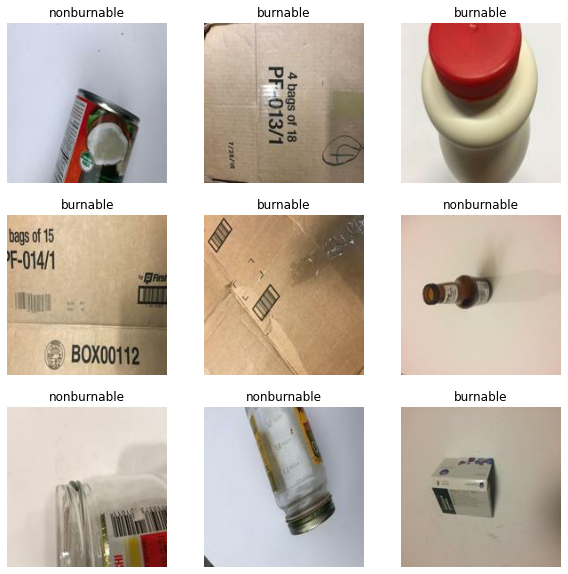

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Create the Model
The `Sequential API` from Keras is used to create the Convolution Neural Network (CNN) model. It uses a linear stack of layers. For this project, it is a combination of 
- Rescaling
- Convolution blocks (Conv2)
- Max Pooling layer (MaxPooling2D)
- Dropout
- Flatten
- Dense
- RandomFlip
- RandomRotation
- RandomZoom

In [6]:
num_classes = 2

# Apply random transformations to the dataset
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
])

# CNN model created using the Sequential API
model = keras.Sequential([
    data_augmentation,
    keras.layers.Rescaling(1. / 255),  # Normalization layer
    keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes)
])

# Compiles the model using the `adam` optimizer and `SparseCategoricalCrossentropy` loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


### Train the Model
- Using 22 epochs is a good fit to train the model.

In [7]:
epochs = 22
history = model.fit(train_ds, validation_data=test_ds, epochs=epochs)

Epoch 1/22
56/56 [==============================] - 23s 395ms/step - loss: 0.7797 - accuracy: 0.6167 - val_loss: 0.6177 - val_accuracy: 0.6464
Epoch 2/22
56/56 [==============================] - 22s 386ms/step - loss: 0.6123 - accuracy: 0.6586 - val_loss: 0.5746 - val_accuracy: 0.6900
Epoch 3/22
56/56 [==============================] - 22s 385ms/step - loss: 0.5728 - accuracy: 0.7123 - val_loss: 0.5548 - val_accuracy: 0.7150
Epoch 4/22
56/56 [==============================] - 22s 387ms/step - loss: 0.5573 - accuracy: 0.7196 - val_loss: 0.5410 - val_accuracy: 0.7388
Epoch 5/22
56/56 [==============================] - 22s 401ms/step - loss: 0.5246 - accuracy: 0.7332 - val_loss: 0.5434 - val_accuracy: 0.7375
Epoch 6/22
56/56 [==============================] - 23s 406ms/step - loss: 0.5029 - accuracy: 0.7462 - val_loss: 0.5159 - val_accuracy: 0.7401
Epoch 7/22
56/56 [==============================] - 22s 391ms/step - loss: 0.4941 - accuracy: 0.7428 - val_loss: 0.4947 - val_accuracy: 0.7546

### Visualizing Accuracy
- Plot both the loss and accuracy on the training and testing datasets
- Display a confusion matrix of the testing data

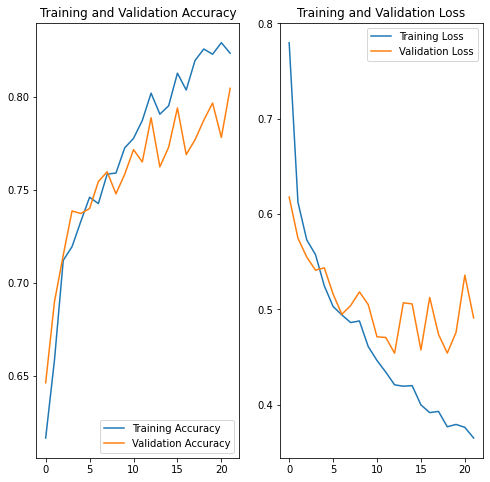

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Prediction Accuracy: 80.47%


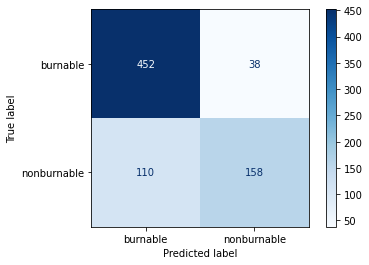

In [9]:
# Create the confusion matrix
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:
   # append true labels
   y_true.append(label_batch)
    
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
true_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

# create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# compute accuracy in confusion matrix
acc = sum([cm[i][i] for i in range(len(cm))]) / np.sum(np.concatenate(cm))
print("Prediction Accuracy: {0:.2f}%".format(acc * 100))

# display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Predict new Data
- The function `test_img(url)` can be used to predict whether a new image shows a garbage that is burnable or not.

In [10]:
def test_img(url):
    # Get the image
    try:
        test_img_path = tf.keras.utils.get_file(origin=url)
        img = tf.keras.utils.load_img(test_img_path, target_size=(img_height, img_width))
    except Exception as e:
        print(e)
        return    
    
    # Display the image
    display(img)

    # Predict the image
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])


    # Display results
    print(
        "The garbage is {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

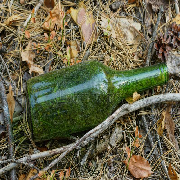

The garbage is nonburnable with a 99.27 percent confidence.


In [11]:
# URL of the picture to test
test_url = "https://thumbs.dreamstime.com/b/garbage-one-green-glass-bottle-garbage-one-green-glass-bottle-gray-dry-vegetation-158505055.jpg"
test_img(test_url)